In [42]:
import numpy as np
import matplotlib.pyplot as plt
from function import M, C, G, gradPhi1, gradPhi2, gradPhi3, torque_Hu, torque_En

# Controller and loop

In [43]:

# Simulation parameters
T_end = 35
step = 0.001
fs = 1000
t = np.arange(0, T_end, step)

# Model parameters
Theta_l = np.array([0.99, 0.12, 0.28, 1.02, 0.2])
Theta_r = np.array([2.14, 0.38, 0.47, 2.0, 0.48])

# Controller parameters
lambda_matrix = np.array([[1, 0], [0, 0.6]])
lambdar_matrix = np.array([[1, 0], [0, 0.6]])

eta_c = 2
eta_a1 = 2
eta_a2 = 4
nuy = 0.01

GAMMA = 2 * np.diag([1, 1, 1, 1, 1, 1, 1])

eta_cr = 2
eta_a1r = 2
eta_a2r = 4
nuyr = 0.01

GAMMAr = 2 * np.diag([1, 1, 1, 1, 1, 1, 1])

# State variables
q_l = np.zeros((len(t), 2))
dq_l = np.zeros((len(t), 2))
ddq_l = np.zeros((len(t), 2))

q_r = np.zeros((len(t), 2))
dq_r = np.zeros((len(t), 2))
ddq_r = np.zeros((len(t), 2))

# Reference trajectory
q_l_ref = np.zeros((len(t), 2))
q_r_ref = np.zeros((len(t), 2))

dq_l_ref = np.zeros((len(t), 2))
dq_r_ref = np.zeros((len(t), 2))

ddq_l_ref = np.zeros((len(t), 2))
ddq_r_ref = np.zeros((len(t), 2))

# Error tracking & Sliding variable
e_l = np.zeros((len(t), 2))
e_r = np.zeros((len(t), 2))

s_l = np.zeros((len(t), 2))
s_r = np.zeros((len(t), 2))

# Time-varying delay
T_l = np.zeros(len(t))
T_r = np.zeros(len(t))

# Control law
torque_l = np.zeros((len(t), 2))
torque_r = np.zeros((len(t), 2))

u_l = np.zeros((len(t), 2))
u_r = np.zeros((len(t), 2))

torque_hu = np.zeros((len(t), 2))
torque_en = np.zeros((len(t), 2))

# Actor - Critic approximated functions
Wl_vc = np.zeros((len(t), 7))
Wl_va = np.zeros((len(t), 7))

Wr_vc = np.zeros((len(t), 7))
Wr_va = np.zeros((len(t), 7))

# Initial condition
Wl_vc[0] = np.zeros(7)
Wl_va[0] = np.zeros(7)

Wr_vc[0] = np.zeros(7)
Wr_va[0] = np.zeros(7)

q_l[0] = np.array([0.5, 0.6])
dq_l[0] = np.array([0, 0])

q_r[0] = np.array([-0.2, 0.3])
dq_r[0] = np.array([0, 0])

# RISE term
sl_0 = 0
sr_0 = 0
ks = np.array([[35, 0], [0, 40]])
ksr = np.array([[40, 0], [0, 35]])
beta = 0.1
betar = 0.1
alpha = np.array([[1.1, 0], [0, 1.1]])
alphar = np.array([[1.1, 0], [0, 1.1]])

muy_l = np.zeros((len(t), 2))
muy_r = np.zeros((len(t), 2))
integral_l = 0
integral_r = 0

# Main loop
for i in range(1, len(t)):
    # Model parameters
    M_l = M(q_l[i - 1], Theta_l)
    C_l = C(q_l[i - 1], dq_l[i - 1], Theta_l)
    G_l = G(q_l[i - 1], Theta_l)

    M_r = M(q_r[i - 1], Theta_r)
    C_r = C(q_r[i - 1], dq_r[i - 1], Theta_r)
    G_r = G(q_r[i - 1], Theta_r)

    T_l[i] = (0.2 + 0.1 * np.sin(2 * t[i]) + 0.1 * np.sin(3 * t[i]))
    T_r[i] = (0.25 + 0.1 * np.sin(2 * t[i]) + 0.05 * np.sin(4 * t[i]))

    dT_l = 1 - (0.2 * np.cos(2 * t[i]) + 0.3 * np.cos(3 * t[i]))
    dT_r = 1 - (0.2 * np.cos(2 * t[i]) + 0.2 * np.cos(4 * t[i]))

    delay_step_l = round(T_l[i] * fs)
    delay_step_r = round(T_r[i] * fs)

    if delay_step_r >= i:
        q_l_ref[i] = np.array([0, 0])
        dq_l_ref[i] = np.array([0, 0])
        ddq_l_ref[i] = np.array([0, 0])
    elif delay_step_r < i:
        q_l_ref[i] = q_r[i - delay_step_r]
        dq_l_ref[i] = dq_r[i - delay_step_r]
        ddq_l_ref[i] = ddq_r[i - delay_step_r]

    if delay_step_l >= i:
        q_r_ref[i] = np.array([0, 0])
        dq_r_ref[i] = np.array([0, 0])
        ddq_r_ref[i] = np.array([0, 0])
    elif delay_step_l < i:
        q_r_ref[i] = q_l[i - delay_step_l]
        dq_r_ref[i] = dq_l[i - delay_step_l]
        ddq_r_ref[i] = ddq_l[i - delay_step_l]

    e_l[i] = q_l_ref[i] - q_l[i]
    e_r[i] = q_r_ref[i] - q_r[i]

    de_l = dT_r * dq_l_ref[i] - dq_l[i]
    de_r = dT_l * dq_r_ref[i] - dq_r[i]

    s_l[i] = de_l + lambda_matrix @ e_l[i]
    s_r[i] = de_r + lambdar_matrix @ e_r[i]

    if i == 1:
        sl_0 = s_l[i]
        sr_0 = s_r[i]
    integral_l = integral_l + ((ks + 1) @ alpha @ s_l[i] + beta * np.sign(s_l[i])) * step
    integral_r = integral_r + ((ksr + 1) @ alphar @ s_r[i] + betar * np.sign(s_r[i])) * step

    muy_l[i] = (ks + 1) @ (s_l[i] - sl_0) + integral_l
    muy_r[i] = (ksr + 1) @ (s_r[i] - sr_0) + integral_r

    X_l = np.concatenate((s_l[i], e_l[i], q_l_ref[i]))
    GradPhi1_l = gradPhi1(X_l)
    GradPhi2_l = gradPhi2(X_l)
    GradPhi3_l = gradPhi3(X_l)
    GradPhi_l = np.concatenate((GradPhi1_l, GradPhi2_l, GradPhi3_l), axis=1)

    X_r = np.concatenate((s_r[i], e_r[i], q_r_ref[i]))
    GradPhi1_r = gradPhi1(X_r)
    GradPhi2_r = gradPhi2(X_r)
    GradPhi3_r = gradPhi3(X_r)
    GradPhi_r = np.concatenate((GradPhi1_r, GradPhi2_r, GradPhi3_r), axis=1)

    u_l[i] = -0.5 * np.linalg.solve(M_l.T, GradPhi1_l.T) @ Wl_va[i]
    u_r[i] = -0.5 * np.linalg.solve(M_r.T, GradPhi1_r.T) @ Wr_va[i]

    torque_hu[i] = torque_Hu(t, i, torque_hu)
    torque_en[i] = torque_En(t, i, torque_en)

    if i <= 3000:
        ex = np.array([1.2, 2.1])
    else:
        ex = np.zeros(2)

    torque_l[i] = muy_l[i] - u_l[i]
    torque_r[i] = muy_r[i] - u_r[i]

    ddq_l[i] = np.linalg.solve(M_l, -C_l @ dq_l[i] - G_l + torque_l[i] + torque_hu[i])
    ddq_r[i] = np.linalg.solve(M_r, -C_r @ dq_r[i] - G_r + torque_r[i] - torque_en[i])

    omega_l = GradPhi1_l @ np.linalg.solve(M_l, -C_l @ s_l[i] + u_l[i]) + GradPhi2_l @ de_l + GradPhi3_l @ dq_l_ref[i] * dT_l
    omega_r = GradPhi1_r @ np.linalg.solve(M_r, -C_r @ s_r[i] + u_r[i]) + GradPhi2_r @ de_r + GradPhi3_r @ dq_r_ref[i] * dT_r
    delta_hjb_l = Wl_vc[i] @ omega_l + 0.5 * np.dot(s_l[i], s_l[i]) + 0.5 * np.dot(u_l[i], u_l[i])
    dWl_vc = -eta_c * GAMMA @ omega_l * delta_hjb_l / (1 + nuy * omega_l @ GAMMA @ omega_l)
    dWl_va = -eta_a1 / np.sqrt(1 + np.dot(omega_l, omega_l)) * GradPhi1_l @ np.linalg.solve(M_l, GradPhi1_l.T) @ (Wl_va[i] - Wl_vc[i]) * delta_hjb_l - eta_a2 * (Wl_va[i] - Wl_vc[i])
    delta_hjb_r = Wr_vc[i] @ omega_r + 0.5 * np.dot(s_r[i], s_r[i]) + 0.5 * np.dot(u_r[i], u_r[i])
    dWr_vc = -eta_cr * GAMMAr @ omega_r * delta_hjb_r / (1 + nuyr * omega_r @ GAMMAr @ omega_r)
    dWr_va = -eta_a1r / np.sqrt(1 + np.dot(omega_r, omega_r)) * GradPhi1_r @ np.linalg.solve(M_r, GradPhi1_r.T) @ (Wr_va[i] - Wr_vc[i]) * delta_hjb_r - eta_a2r * (Wr_va[i] - Wr_vc[i])

    if i == len(t) - 1:
        break

    dq_l[i + 1] = dq_l[i] + step * ddq_l[i]
    dq_r[i + 1] = dq_r[i] + step * ddq_r[i]

    q_l[i + 1] = q_l[i] + step * dq_l[i]
    q_r[i + 1] = q_r[i] + step * dq_r[i]

    Wl_vc[i + 1] = Wl_vc[i] + step * dWl_vc
    Wl_va[i + 1] = Wl_va[i] + step * dWl_va

    Wr_vc[i + 1] = Wr_vc[i] + step * dWr_vc
    Wr_va[i + 1] = Wr_va[i] + step * dWr_va


# Result

In [44]:
ql = np.array(q_l)
ql_ref = np.array(q_l_ref)
qr = np.array(q_r)
qr_ref = np.array(q_r_ref)
t_hu = np.array(torque_hu)
t_en = np.array(torque_en)
Wlc = np.array(Wl_vc)
Wla = np.array(Wl_va)
Wrc = np.array(Wr_vc)
Wra = np.array(Wr_va)
uadp_l = np.array(u_l)
uadp_r = np.array(u_r)
uRise_l = np.array(muy_l)
uRise_r = np.array(muy_r)
torquel = np.array(torque_l)
torquer = np.array(torque_r)
el = np.array(e_l)
Tl = np.array(T_l)
Tr = np.array(T_r)

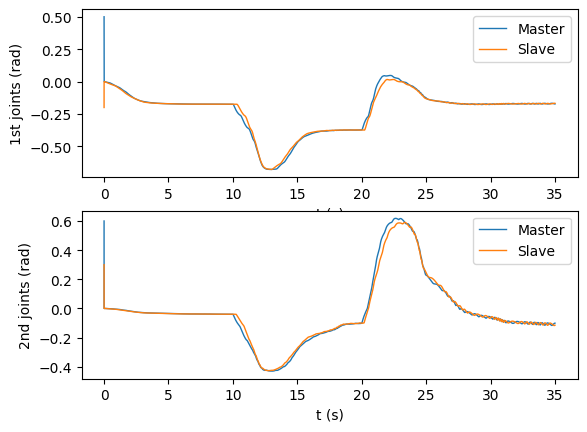

In [45]:
plt.subplot(2, 1, 1)
plt.plot(t, ql[:, 0], linewidth=1)
plt.plot(t, qr[:, 0], linewidth=1)
# plt.axis([0, T_end, -0.5, 1])
plt.legend(["Master", "Slave"])
plt.ylabel("1st joints (rad)")
plt.xlabel("t (s)")
plt.subplot(2, 1, 2)
plt.plot(t, ql[:, 1], linewidth=1)
plt.plot(t, qr[:, 1], linewidth=1)
# plt.axis([0, T_end, 0, 3])
plt.legend(["Master", "Slave"])
plt.ylabel("2nd joints (rad)")
plt.xlabel("t (s)")
plt.show()

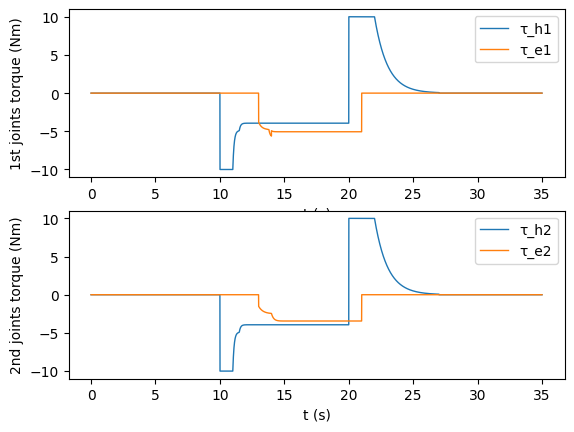

In [46]:
plt.subplot(2, 1, 1)
plt.plot(t, t_hu[:, 1], linewidth=1)
plt.plot(t, t_en[:, 0], linewidth=1)
plt.legend(["τ_h1", "τ_e1"])
plt.ylabel("1st joints torque (Nm)")
plt.xlabel("t (s)")
plt.subplot(2, 1, 2)
plt.plot(t, t_hu[:, 1], linewidth=1)
plt.plot(t, t_en[:, 1], linewidth=1)
plt.legend(["τ_h2", "τ_e2"])
plt.ylabel("2nd joints torque (Nm)")
plt.xlabel("t (s)")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

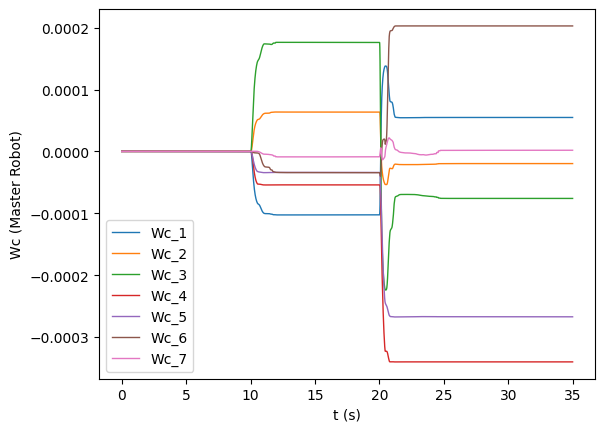

In [47]:
plt.plot(t, Wlc, linewidth=1)
plt.legend(["Wc_1", "Wc_2", "Wc_3", "Wc_4", "Wc_5", "Wc_6", "Wc_7"])
plt.ylabel("Wc (Master Robot)")
plt.xlabel("t (s)")
plt.show

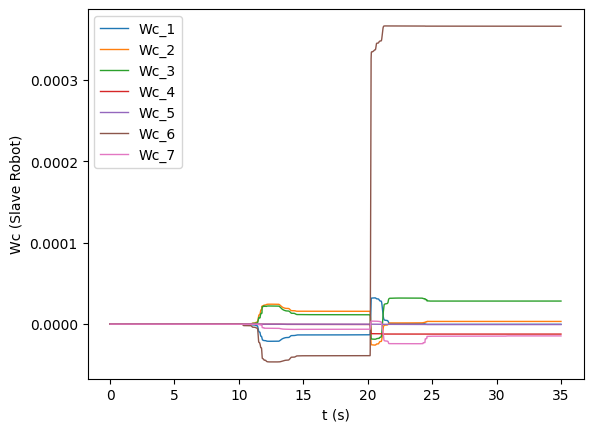

In [48]:
plt.plot(t, Wrc, linewidth=1)
plt.legend(["Wc_1", "Wc_2", "Wc_3", "Wc_4", "Wc_5", "Wc_6", "Wc_7"])
plt.ylabel("Wc (Slave Robot)")
plt.xlabel("t (s)")
plt.show()

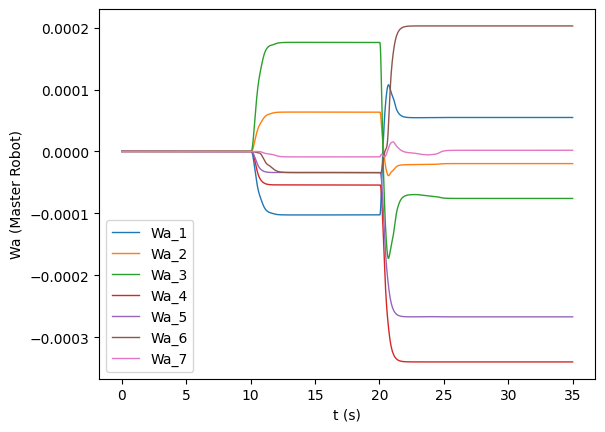

In [49]:
plt.plot(t, Wla, linewidth=1)
plt.legend(["Wa_1", "Wa_2", "Wa_3", "Wa_4", "Wa_5", "Wa_6", "Wa_7"])
plt.ylabel("Wa (Master Robot)")
plt.xlabel("t (s)")
plt.show()

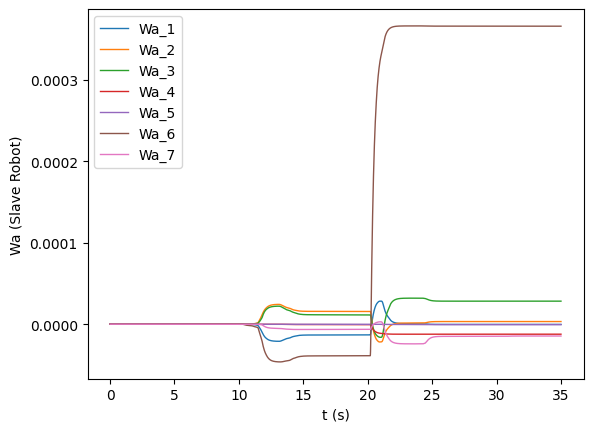

In [50]:
plt.plot(t, Wra, linewidth=1)
plt.legend(["Wa_1", "Wa_2", "Wa_3", "Wa_4", "Wa_5", "Wa_6", "Wa_7"])
plt.ylabel("Wa (Slave Robot)")
plt.xlabel("t (s)")
plt.show()

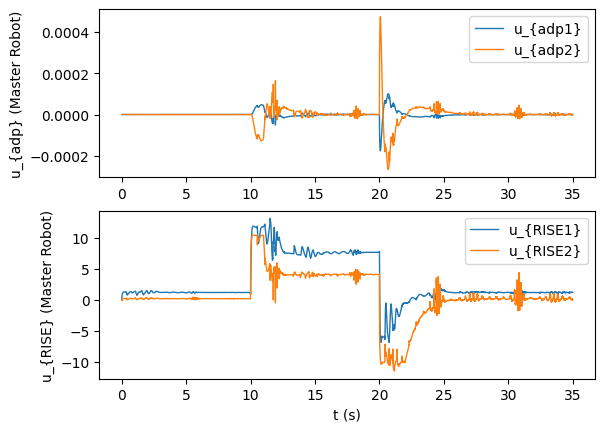

In [51]:
plt.subplot(2, 1, 1)
plt.plot(t, uadp_l, linewidth=1)
plt.legend(["u_{adp1}", "u_{adp2}"])
plt.ylabel("u_{adp} (Master Robot)")
plt.subplot(2, 1, 2)
plt.plot(t, uRise_l, linewidth=1)
plt.legend(["u_{RISE1}", "u_{RISE2}"])
plt.ylabel("u_{RISE} (Master Robot)")
plt.xlabel("t (s)")
plt.show()

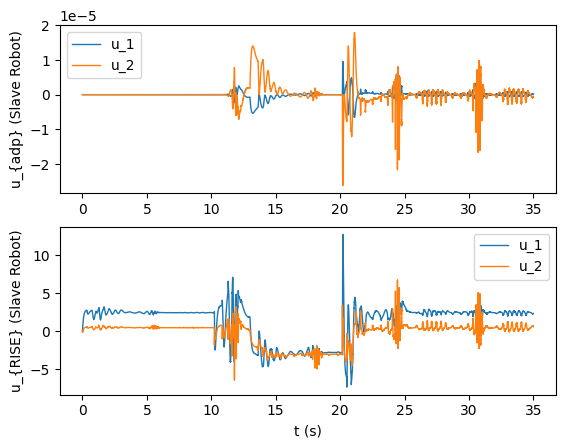

In [52]:
plt.subplot(2, 1, 1)
plt.plot(t, uadp_r, linewidth=1)
plt.legend(["u_1", "u_2"])
plt.ylabel("u_{adp} (Slave Robot)")
plt.subplot(2, 1, 2)
plt.plot(t, uRise_r, linewidth=1)
plt.legend(["u_1", "u_2"])
plt.ylabel("u_{RISE} (Slave Robot)")
plt.xlabel("t (s)")
plt.show()